<a href="https://colab.research.google.com/github/AnastasiiaVladimirovna/transcriptomics_homeworks/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сначала все скачаем, установим

In [ ]:
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown "1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck&confirm=t"
!tar xf library.tar.gz

In [ ]:
!pip install rpy2==3.5.1

In [ ]:
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidyr")'
!Rscript -e 'install.packages("stringr")'
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("MASS")'

In [ ]:
%%R

suppressPackageStartupMessages({
  library(edgeR)
  library(stringr)
  library(dplyr)
  library(tidyr)
  library(tximport)
  library(EnsDb.Mmusculus.v79)
  library(ggplot2)
  library(MASS)
  library(DESeq2)
})

In [ ]:
!wget -r -np -R "index.html*" http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/samples/

In [ ]:
!mkdir data
!mkdir data/samples

!mv arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/samples/* data/samples

In [ ]:
%%R

txdb <- EnsDb.Mmusculus.v79
tx2gene <- transcripts(txdb,return.type="DataFrame")
tx2gene <- tx2gene[c("tx_id","gene_id")]

samples <- str_c(c(str_c("wt_water_",c(1,2,3,4)),
                   str_c("wt_bicarb_",c(1,2,3,4)),
                   str_c("ko_water_",c(1,2,3,4)),
                   str_c("ko_bicarb_",c(1,2,3,4))),".sf")
files <- str_c("data/samples/",samples)

In [ ]:
%%R

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion=T)

In [ ]:
%%R

cts <- txi$counts

In [ ]:
!wget -O data/mouse_mart.csv http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/mouse_mart.csv

--2022-12-17 13:24:57--  http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/mouse_mart.csv
Resolving arcuda.skoltech.ru (arcuda.skoltech.ru)... 195.133.216.197
Connecting to arcuda.skoltech.ru (arcuda.skoltech.ru)|195.133.216.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13518751 (13M)
Saving to: ‘data/mouse_mart.csv’

data/mouse_mart.csv 100%[===================>]  12.89M   300KB/s    in 67s     

2022-12-17 13:26:05 (196 KB/s) - ‘data/mouse_mart.csv’ saved [13518751/13518751]



In [ ]:
%%R

mart <- read.csv("data/mouse_mart.csv")
genetype <- mart$Gene.type[match(rownames(cts),mart$Gene.stable.ID)]
typefilter <- genetype == "protein_coding"
typefilter[is.na(typefilter)] <- FALSE
cts <- cts[typefilter,]
# normMat <- normMat[typefilter,]
txi$counts <- txi$counts[typefilter,]
txi$abundance <- txi$abundance[typefilter, ]
txi$length <- txi$length[typefilter, ]

In [ ]:
%%R
str(cts)

 num [1:21153, 1:16] 745 0 18 4 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:21153] "ENSMUSG00000000001" "ENSMUSG00000000003" "ENSMUSG00000000028" "ENSMUSG00000000037" ...
  ..$ : NULL


In [ ]:
%%R
sampleTable <- data.frame(condition = factor(rep(c("wt_water", "wt_bicarb", "ko_water", "ko_bicarb"), each = 4)))
rownames(sampleTable) <- colnames(txi$counts)

Теперь все выгрузим в DESeq2

In [ ]:
%%R
dds <- DESeqDataSetFromTximport(txi, sampleTable, ~condition)

In [ ]:
%%R
dds <- DESeq(dds)

In [ ]:
%%R
str(dds)

Formal class 'DESeqDataSet' [package "DESeq2"] with 8 slots
  ..@ design            :Class 'formula'  language ~condition
  .. .. ..- attr(*, ".Environment")=<environment: R_GlobalEnv> 
  ..@ dispersionFunction:function (q)  
  .. ..- attr(*, "coefficients")= Named num [1:2] 0.00966 5.38563
  .. .. ..- attr(*, "names")= chr [1:2] "asymptDisp" "extraPois"
  .. ..- attr(*, "fitType")= chr "parametric"
  .. ..- attr(*, "varLogDispEsts")= num 1.39
  .. ..- attr(*, "dispPriorVar")= num 1.21
  ..@ rowRanges         :Formal class 'CompressedGRangesList' [package "GenomicRanges"] with 5 slots
  .. .. ..@ unlistData     :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. ..@ values         : Factor w/ 0 levels: 
  .. .. .. .. .. .. ..@ lengths        : int(0) 
  .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. ..@ ranges 

In [ ]:
%%R
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep, ]

In [ ]:
%%R
resultsNames(dds)

[1] "Intercept"                        "condition_ko_water_vs_ko_bicarb" 
[3] "condition_wt_bicarb_vs_ko_bicarb" "condition_wt_water_vs_ko_bicarb" 


Построим Volcano plots для пары condition_wt_bicarb_vs_ko_bicarb

In [ ]:
%%R
res <- results(dds, name="condition_wt_bicarb_vs_ko_bicarb")
res

log2 fold change (MLE): condition wt bicarb vs ko bicarb 
Wald test p-value: condition wt bicarb vs ko bicarb 
DataFrame with 15942 rows and 6 columns
                     baseMean log2FoldChange     lfcSE      stat      pvalue
                    <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001  786.28271      0.3649160  0.070587  5.169736 2.34425e-07
ENSMUSG00000000028   18.19808      0.0942659  0.343466  0.274454 7.83735e-01
ENSMUSG00000000037    4.72771      1.2191366  1.187724  1.026448 3.04681e-01
ENSMUSG00000000049    1.16603      0.1468187  1.319620  0.111258 9.11411e-01
ENSMUSG00000000056  706.89922     -0.3102665  0.120680 -2.570995 1.01407e-02
...                       ...            ...       ...       ...         ...
ENSMUSG00000104063  68.250433      -0.377420  0.257861 -1.463659    0.143287
ENSMUSG00000104148   0.941004      -2.516111  2.312084 -1.088244    0.276487
ENSMUSG00000104217  27.399232      -0.680388  1.263086 -0.538672    0.590114
EN

In [ ]:
%%R
res <- na.omit(res)

In [ ]:
%%R
for_plot <- data.frame(x = res$log2FoldChange, y = -log10(res$padj))

In [ ]:
%%R
head(for_plot)

            x          y
1  0.36491597 5.25019180
2  0.09426587 0.05243775
3 -0.31026652 1.33013226
4  0.24687703 0.67762342
5 -0.14543918 0.86484908
6 -0.79240890 3.12553854


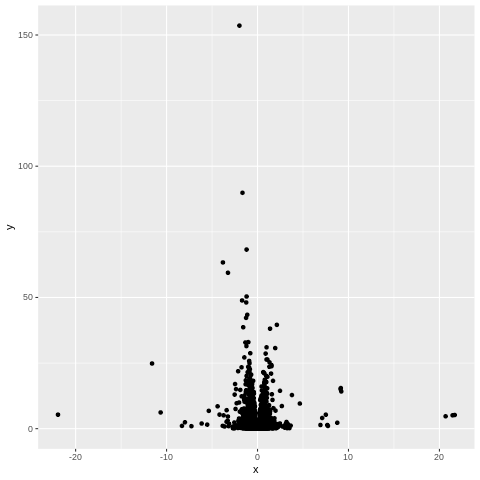

In [ ]:
%%R

ggplot(for_plot, aes(x=x,y=y))+
  geom_point()